# HIVE: _in vitro_ dataset processing

###### An introduction to processing HIVE datasets

## Configuration
We use [pyhocon](https://github.com/chimpler/pyhocon) to parse a [HOCON](https://github.com/lightbend/config/blob/master/HOCON.md) file which describes configuration parameters for our project

In [2]:
from pyhocon import ConfigFactory

cfg = ConfigFactory.parse_file('../matlab/treatment-burst-008.conf')

Here is the list of chemicals supported in the loaded configuration...

In [3]:
chems = sorted(cfg['chemicals'], key=lambda c: c.ix)

for c in chems:
    print(f'#{c.ix}: {c.name} ({c.neutral}{c.units})')

#1: Dopamine (0.0nM)
#2: Serotonin (0.0nM)
#3: pH (7.4)
#4: Norepinephrine (0.0nM)
#5: HydroxyindoleaceticAcid (0.0nM)


...and here is the information we need to import training data

In [4]:
print('input directories:')
for s in cfg['training.source-spec']:
    print(f'    {s}')
    
print()
print(f'raw files: {cfg["training.raw-spec"]}')
print(f'label files: {cfg["training.label-spec"]}')

input directories:
    /data/hnl/iterate/results_008/training-A-0400Vs-010Hz/20*
    /data/hnl/iterate/results_008/training-B-0400Vs-097Hz/20*
    /data/hnl/iterate/results_008/training-C-RBV001-097Hz/20*
    /data/hnl/iterate/results_008/training-E-0400Vs-097Hz/20*
    /data/hnl/iterate/results_008/training-F-RBV001-097Hz/20*
    /data/hnl/iterate/results_008/training-X-RBV001-097Hz/20*

raw files: *.abf
label files: *.csv


There is a lot more information in the config file. Check it out... it's fairly human-readable.

## Import and conversion
First, we'll find our source directories

In [5]:
from pathlib import Path

# we'll focus on the last source of the second set
set_id = 1
src_id = -1

training_spec = cfg['training.source-spec'][set_id]
source_root = Path(training_spec).parent
source_spec = Path(training_spec).name

print(f'set {set_id}: {source_root.name}')

source_dir_list = sorted(source_root.glob(source_spec))

print(f'set {set_id} sources:')
for d in source_dir_list:
    print(f'    {d.name}')

src_id += len(source_dir_list) # cosmetics
source_dir = source_dir_list[src_id]

print()
print(f'source {src_id}: {source_dir.name}')

raw_file_list = sorted(source_dir.glob(cfg['training.raw-spec']))

print(f'source {src_id} raw files: {len(raw_file_list)}')

label_file_list = sorted(source_dir.glob(cfg['training.label-spec']))

print(f'source {src_id} label files: {len(label_file_list)}')

set 1: training-B-0400Vs-097Hz
set 1 sources:
    2018_03_27_5HT_5HIAA_pH_400Vs_97Hz_CF003_2018_03_24
    2018_04_13_5HT_5HIAA_pH_400Vs_97Hz_CF007_2018_04_12
    2018_05_31_5HT_5HIAA_pH_400Vs_97Hz_CF006
    2018_06_07_5HT_5HIAA_pH_400Vs_97Hz_CF009
    2018_06_12_5HT_5HIAA_pH_400Vs_97Hz_CF010
    2018_06_12_5HT_5HIAA_pH_400Vs_97Hz_CF013
    2018_07_12_5HT_5HIAA_pH_400Vs_97Hz_CF014
    2018_09_04_5HT_5HIAA_DA_pH_400Vs_97Hz_CF017
    2018_09_05_5HT_5HIAA_DA_pH_400Vs_97Hz_CF017
    2018_09_06_5HT_5HIAA_DA_pH_400Vs_97Hz_CF017
    2018_09_07_5HT_5HIAA_DA_pH_400Vs_97Hz_CF017
    2018_09_08_5HT_5HIAA_DA_pH_400Vs_97Hz_CF017
    2018_09_14_5HT_5HIAA_pH_400Vs_97Hz_PT001
    2018_09_19_5HT_5HIAA_pH_400Vs_97Hz_BF001W1R6
    2018_09_20_5HT_5HIAA_pH_400Vs_97Hz_PT002
    2018_09_26_5HT_5HIAA_pH_400Vs_97Hz_WX001
    2018_12_13_DA_5HT_NE_5HIAA_400Vs_97Hz_MM001W11R14
    2018_12_14_DA_5HT_NE_5HIAA_400Vs_97Hz_CF022
    2018_12_20_DA_5HT_NE_5HIAA_400Vs_97Hz_MM001W11R14
    2018_12_21_DA_5HT_NE_5HIAA_400Vs_

Next, we'll use [pyabf](https://github.com/swharden/pyABF) to read in data files.

In [6]:
import pyabf

abf = pyabf.ABF(abf=raw_file_list[1], preLoadData=True)

voltage_chan = abf.adcNames.index('Cmd')
current_chan = abf.adcNames.index('FSCV_1')
sweep_count = abf.sweepCount
sweep_samples = abf.sweepPointCount
sample_freq = abf.dataRate
sweep_freq = sample_freq / sweep_samples

current = abf.data[current_chan].reshape(sweep_count, sweep_samples)
voltage = abf.data[voltage_chan].reshape(sweep_count, sweep_samples)



IndexError: list index out of range

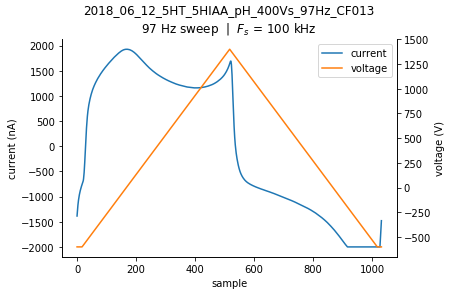

In [6]:
import matplotlib.pyplot as plt

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

fig, ax = plt.subplots()

ln = ax.plot(current[500, :], color=colors[0], label='current')
ax.spines['top'].set_color('none')
ax.set_xlabel('sample')
ax.set_ylabel('current (nA)')

ax2 = ax.twinx()
ln2 = ax2.plot(voltage[500, :], color=colors[1], label='voltage')
ax2.spines['top'].set_color('none')
ax2.set_ylabel('voltage (V)')

lns = ln + ln2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs)

ax.set_title(f'{source_dir.name}\n'
             +f'{round(sweep_freq)} Hz sweep  |  '
             +r'$F_{s}$ '
             +f'= {round(sample_freq / 1e3)} kHz')

plt.show()